https://www.kaggle.com/code/tahmidmir/sentiment-analysis-bert-xai/input

基于BERT和XAI的社交媒体情绪分析

可解释的AI

可解释人工智能（XAI）是指一组方法、技术和工具，旨在使人工智能（AI）和机器学习（ML）模型的决策过程对人类来说是可理解的。随着人工智能系统变得越来越复杂，成为社会各个方面不可或缺的一部分——从医疗保健和金融到自动驾驶汽车和社交媒体——越来越需要确保其运营透明、值得信赖和负责。XAI通过提供对人工智能模型如何得出结论的见解来满足这一需求，使用户能够理解、信任和有效管理人工智能驱动的结果。

介绍

情感分析是一项至关重要的自然语言处理（NLP）任务，涉及确定一段文本是表达积极、消极还是中性的情感。该项目利用基于BERT的变压器对社交媒体帖子，特别是推文进行情绪分析。此外，像LIME这样的可解释人工智能（XAI）工具被用来解释模型的预测，提供哪些单词或短语对情绪分类影响最大的见解。

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# NLP Libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [3]:

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [4]:
# Transformers and Tokenization
#!pip install -q transformers
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [5]:
# Explainable AI Libraries
#!pip install -q lime
from lime.lime_text import LimeTextExplainer

In [6]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Download NLTK data with checks
import os

nltk_data_path = os.path.join(os.path.expanduser('~'), 'nltk_data')


In [8]:
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)

nltk.data.path.append(nltk_data_path)

In [9]:
required_packages = ['stopwords', 'wordnet', 'omw-1.4']

for package in required_packages:
    try:
        nltk.data.find(f'corpora/{package}')
    except LookupError:
        print(f'Downloading NLTK package: {package}')
        nltk.download(package, download_dir=nltk_data_path)

[nltk_data] Error loading wordnet: <urlopen error [WinError 10053]
[nltk_data]     你的主机中的软件中止了一个已建立的连接。>
[nltk_data] Error loading omw-1.4: <urlopen error [WinError 10053]
[nltk_data]     你的主机中的软件中止了一个已建立的连接。>


Ensure Proper NLTK Data Download

In [10]:
# Import necessary libraries
import nltk

# Download required NLTK data packages
nltk.download('wordnet')
nltk.download('omw-1.4')  # Necessary for WordNet lemmatizer
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Error loading wordnet: <urlopen error [WinError 10054]
[nltk_data]     远程主机强迫关闭了一个现有的连接。>
[nltk_data] Error loading omw-1.4: <urlopen error [WinError 10054]
[nltk_data]     远程主机强迫关闭了一个现有的连接。>
[nltk_data] Error loading stopwords: <urlopen error [WinError 10053]
[nltk_data]     你的主机中的软件中止了一个已建立的连接。>


Verify NLTK Data Path

In [11]:
import os

# Define a directory to store NLTK data
nltk_data_dir = os.path.join(os.getcwd(), 'nltk_data')

# Create the directory if it doesn't exist
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Add the directory to NLTK's data path
nltk.data.path.append(nltk_data_dir)

# Download required NLTK data packages to the specified directory
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)

[nltk_data] Error loading wordnet: <urlopen error [WinError 10054]
[nltk_data]     远程主机强迫关闭了一个现有的连接。>
[nltk_data] Error loading omw-1.4: <urlopen error [WinError 10053]
[nltk_data]     你的主机中的软件中止了一个已建立的连接。>
[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     远程主机强迫关闭了一个现有的连接。>


False

Dataset Acquisition and Preprocessing

In [12]:
os.chdir('E:\Python code\Tweets')
# Load the dataset
df = pd.read_csv('Tweets.csv')

# Display the first few rows
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Exploratory Data Analysis (EDA)

Dataset contains 14640 rows and 15 columns.

Missing values in each column:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


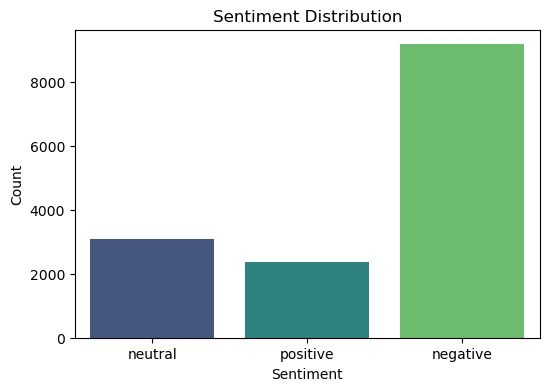

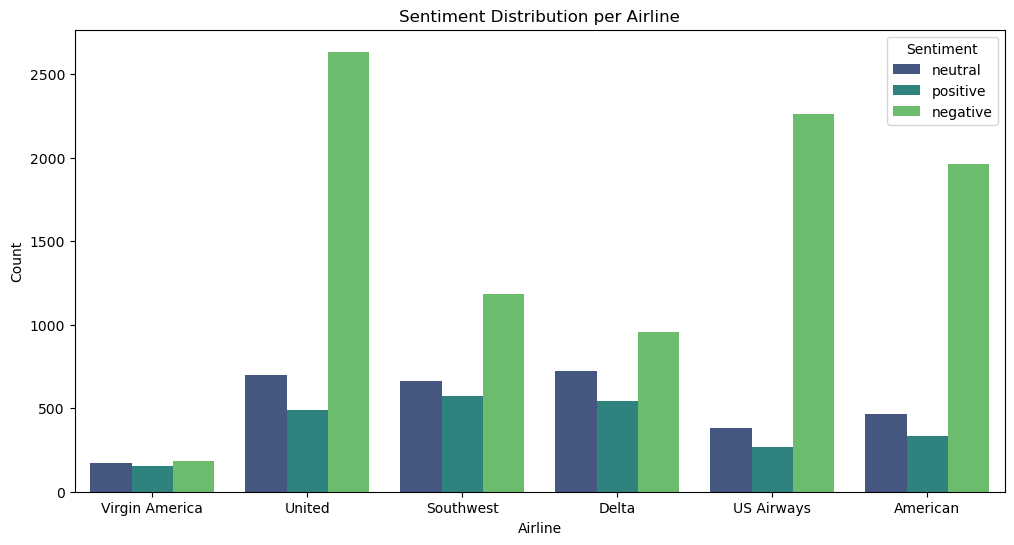

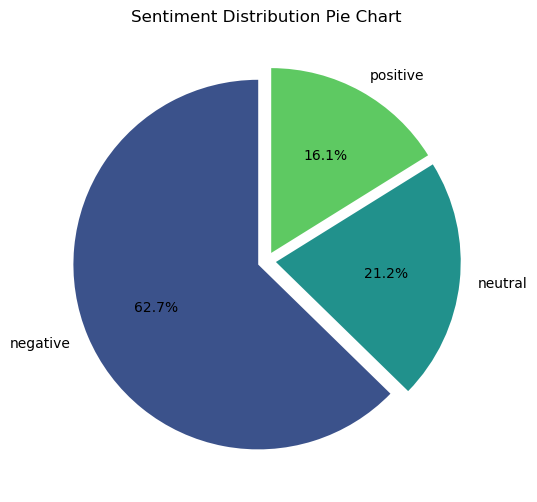

In [13]:
# Check the shape of the dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Distribution of sentiments
plt.figure(figsize=(6,4))
sns.countplot(x='airline_sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Distribution of sentiments per airline
plt.figure(figsize=(12,6))
sns.countplot(x='airline', hue='airline_sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution per Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Pie chart for sentiment distribution
plt.figure(figsize=(6,6))
df['airline_sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('viridis', 3), startangle=90, explode=[0.05]*3)
plt.title('Sentiment Distribution Pie Chart')
plt.ylabel('')  # To remove the y-label
plt.show()

# Data Preprocessing

In [14]:
def preprocess_text(text):
    # Check if text is a string
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#','', text)
    
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

# Display cleaned text
df[['text', 'clean_text']].head()

,text,clean_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials t...,plus you ve added commercials to the experienc...
2,@VirginAmerica I didn't today... Must mean I n...,didn today must mean need to take another trip
3,@VirginAmerica it's really aggressive to blast...,it really aggressive to blast obnoxious entert...
4,@VirginAmerica and it's a really big bad thing...,and it a really big bad thing about it


# Feature Extraction

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define features and labels
X = df['clean_text']
y = df['airline_sentiment'].map({'negative':0, 'neutral':1, 'positive':2})  # Encoding sentiments

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform the data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 1. Encoding Labels

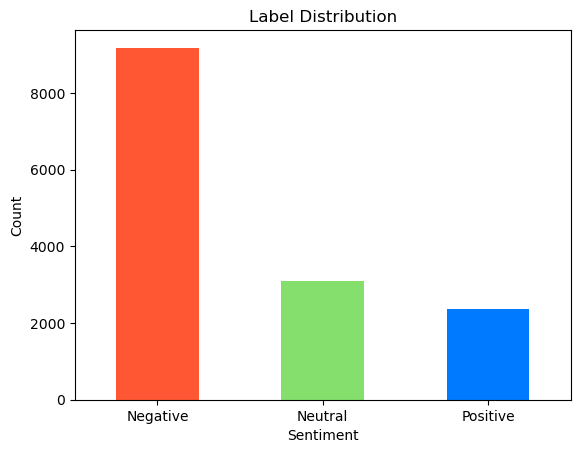

In [16]:
# Encode sentiments
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(label_mapping)

# Display label distribution with custom colors
colors = ['#FF5733', '#85df6d', '#007BFF']  # Example colors: red, light green, and blue

df['label'].value_counts().sort_index().plot(kind='bar', color=colors)
plt.title('Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'], rotation=0)
plt.show()

# 2. Splitting the Dataset

In [17]:
# Define features and labels
X = df['clean_text']
y = df['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 11712
Testing set size: 2928


# 3. Tokenization

In [18]:
from transformers import BertTokenizer

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=128
    )

# Tokenize training and testing data
train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# 4. Creating Dataset Objects

In [19]:
import torch
from torch.utils.data import Dataset

class TweetsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create dataset objects
train_dataset = TweetsDataset(train_encodings, y_train.tolist())
test_dataset = TweetsDataset(test_encodings, y_test.tolist())

# 5. Fine-Tuning BERT

In [20]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Initialize the model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,  # Negative, Neutral, Positive
    output_attentions=False,
    output_hidden_states=False
)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=64,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

# Define a metric computation function
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.403700,0.492699,0.819672,0.814085,0.816178,0.819672
2,0.280500,0.469266,0.830601,0.829058,0.829542,0.830601
3,0.045400,0.654499,0.834358,0.833446,0.832795,0.834358


TrainOutput(global_step=2196, training_loss=0.36557075430135255, metrics={'train_runtime': 659.684, 'train_samples_per_second': 53.262, 'train_steps_per_second': 3.329, 'total_flos': 722246331663360.0, 'train_loss': 0.36557075430135255, 'epoch': 3.0})

In [22]:
# Evaluate the model
trainer.evaluate()

{'eval_loss': 0.6544990539550781,
 'eval_accuracy': 0.8343579234972678,
 'eval_f1': 0.8334455860445266,
 'eval_precision': 0.8327953102879999,
 'eval_recall': 0.8343579234972678,
 'eval_runtime': 9.8674,
 'eval_samples_per_second': 296.735,
 'eval_steps_per_second': 4.662,
 'epoch': 3.0}

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.91      0.90      1835
     Neutral       0.69      0.68      0.69       620
    Positive       0.78      0.74      0.76       473

    accuracy                           0.83      2928
   macro avg       0.79      0.78      0.78      2928
weighted avg       0.83      0.83      0.83      2928



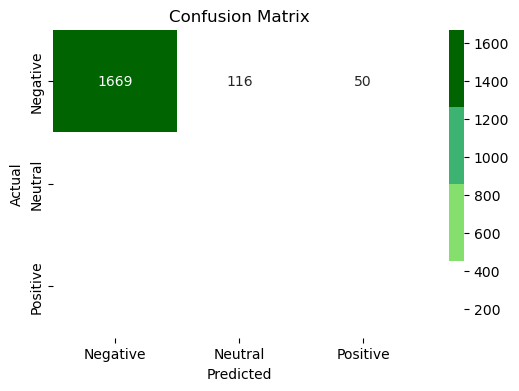

Accuracy: 83.44%


In [23]:
import matplotlib.colors as mcolors

# Predictions
predictions, true_labels, _ = trainer.predict(test_dataset)
preds = np.argmax(predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, preds, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))

# Create a custom colormap
cmap = mcolors.ListedColormap(['#ffffff', '#85df6d', '#3cb371', '#006400'])  # White to light green to dark green

sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

2. Preparing the Explainer

In [24]:
from lime.lime_text import LimeTextExplainer

# Define class names
class_names = ['Negative', 'Neutral', 'Positive']

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

3. Defining a Prediction Function

In [25]:
def predict_proba(texts):
    # Tokenize the texts
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    # Move tensors to the same device as the model
    encodings = {key: val.to(model.device) for key, val in encodings.items()}
    
    # Get logits from the model
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs

5. Explaining a Single Predictions

In [27]:
# Select a sample from the test set
sample_idx = 42  # You can change this index to explore different samples
sample_text = X_test.iloc[sample_idx]
actual_sentiment = y_test.iloc[sample_idx]
predicted_sentiment = preds[sample_idx]

print(f"Original Tweet: {df.iloc[X_test.index[sample_idx]]['text']}")
print(f"Cleaned Tweet: {sample_text}")
print(f"Actual Sentiment: {class_names[actual_sentiment]}")
print(f"Predicted Sentiment: {class_names[predicted_sentiment]}")

Original Tweet: @JetBlue Do you have any flights with lie flat seating from STL to PDX on or around the date of March 5?
Cleaned Tweet: do you have any flights with lie flat seating from stl to pdx on or around the date of march
Actual Sentiment: Neutral
Predicted Sentiment: Neutral


In [28]:

# Generate explanation
exp = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10,
    labels=[predicted_sentiment]
)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "D:\anaconda\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_29120\2382334457.py", line 2, in <module>
    exp = explainer.explain_instance(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda\Lib\site-packages\lime\lime_text.py", line 413, in explain_instance
    data, yss, distances = self.__data_labels_distances(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda\Lib\site-packages\lime\lime_text.py", line 482, in __data_labels_distances
    labels = classifier_fn(inverse_data)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_29120\2335842831.py", line 15, in predict_proba
    outputs = model(**encodings)
              ^^^^^^^^^^^^^^^^^^
  File "D:\anaconda\Lib\site-packages\torch\nn\modules\module.py", line 1553, in _wr

In [29]:
# Function to display explanations for multiple samples
def display_lime_explanations(texts, labels, preds, num_samples=3):
    for i in range(num_samples):
        idx = np.random.randint(0, len(texts))
        text = texts.iloc[idx]
        actual = labels.iloc[idx]
        pred = preds[idx]
        print(f"\nSample {i+1}")
        print(f"Original Tweet: {df.iloc[X_test.index[idx]]['text']}")
        print(f"Cleaned Tweet: {text}")
        print(f"Actual Sentiment: {class_names[actual]}")
        print(f"Predicted Sentiment: {class_names[pred]}")
        exp = explainer.explain_instance(
            text,
            predict_proba,
            num_features=10,
            labels=[pred]
        )
        exp.show_in_notebook(text=True)

# Display explanations for 3 random samples
display_lime_explanations(X_test, y_test, preds, num_samples=3)


Sample 1
Original Tweet: @JetBlue wondering if it's possible for my colleague and I to get on an earlier flight LAX&gt;JFK tomorrow. Can you help?
Cleaned Tweet: wondering if it possible for my colleague and to get on an earlier flight lax gt jfk tomorrow can you help
Actual Sentiment: Neutral
Predicted Sentiment: Neutral
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "D:\anaconda\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_29120\3078272460.py", line 22, in <module>
    display_lime_explanations(X_test, y_test, preds, num_samples=3)
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_29120\3078272460.py", line 13, in display_lime_explanations
    exp = explainer.explain_instance(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda\Lib\site-packages\lime\lime_text.py", line 413, in explain_instance
    data, yss, distances = self.__data_labels_distances(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda\Lib\site-packages\lime\lime_text.py", line 482, in __data_labels_distances
    labels = classifier_fn(inverse_data)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_29120\233